# Solution Notebook for Business Problem
Helps entrepreneurs to establish **new businesses** in the city of **Toronto** select an ideal business location based on the ethnic communities they want to be a part of.    

This service will help find an ideal location for a new business based on such factors as business venue, population density in the area, the demographics in the area, average income, proximity to other business venues.

### Scrapping Wikipedia page containing Toronto Neighborhoods.
<a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>Neighbourhoods in canada</a>

In [96]:
# importing required libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 25)
import requests
from bs4 import BeautifulSoup

In [97]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.text,'lxml')

In [98]:
tables = soup.find_all('table')  # gives a list of all tables in page

Toronto = pd.read_html(str(tables[0]), index_col=None, header=0)[0] #Read HTML tables into a list of DataFrame objects.Reading zero index dataframe in list 
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Data Cleaning

In [99]:
# Leave behind rows containing 'Not assigned' in 'Borough'
Toronto = Toronto[Toronto['Borough'] != 'Not assigned']
# Replace Neighbourhoods with 'Not assigned' to their Burough name
Toronto['Neighbourhood'].replace('Not assigned',Toronto['Borough'],inplace=True)

Toronto.reset_index(drop=True,inplace=True)
print('Shape of the data frame ',Toronto.shape)
Toronto.head()

Shape of the data frame  (212, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


### Obtaining geospatial data of Toronto
By importing the CSV file from <a href='https://cocl.us/Geospatial_data'>https://cocl.us/Geospatial_data</a>

In [100]:
lat_long_df=pd.read_csv('https://cocl.us/Geospatial_data')
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [101]:
print('Shape of data frame ',lat_long_df.shape)

Shape of data frame  (103, 3)


In [102]:
Toronto=pd.merge(Toronto,lat_long_df, left_on='Postcode' , right_on='Postal Code')
Toronto.drop('Postal Code',axis=1,inplace=True)
Toronto.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
6,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
7,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
8,M1B,Scarborough,Rouge,43.806686,-79.194353
9,M1B,Scarborough,Malvern,43.806686,-79.194353


In [103]:
Toronto.shape

(212, 5)

In [104]:
# importing Additional Required Modulus

import json
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt # data Visualization library
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Obtaining Demographics of Toronto Neighbourhoods data from Wikipedia Page.
<a href='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'>Demographics of Toronto Neighbourhoods</a>                           
Demography encompasses the study of the size, structure, and distribution of these populations, and spatial or temporal changes in them in response to birth, migration, aging, and death.

In [105]:
res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')

In [106]:
wikitables = soup.find_all('table') 
print('Number of tables obtained from wikipedia is',len(wikitables))

Number of tables obtained from wikipedia is 5


In [107]:
Toronto_Demographics = pd.read_html(str(wikitables[1]), index_col=None, header=0)[0] #Read HTML tables into a list of DataFrame objects
Toronto_Demographics.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [108]:
df_dens = pd.DataFrame(Toronto_Demographics[['Name','Population','Land area (km2)', 'Average Income', 'Density (people/km2)', '% Change in Population since 2001']])
df_dens.drop([0], inplace=True) # dropping the first row in dataframe which is average and not required.  
df_dens.head()

,Name,Population,Land area (km2),Average Income,Density (people/km2),% Change in Population since 2001
1,Agincourt,44577,12.45,25750,3580,4.6
2,Alderwood,11656,4.94,35239,2360,-4.0
3,Alexandra Park,4355,0.32,19687,13609,0.0
4,Allenby,2513,0.58,245592,4333,-1.0
5,Amesbury,17318,3.51,27546,4934,1.1


In [109]:
df_dens.rename(columns={'% Change in Population since 2001': 'Change'}, inplace=True)        
df_dens = df_dens.reset_index(drop=True)                                                 
df_dens.set_index(['Name'], inplace=True)
df_dens = df_dens.sort_values(['Population', 'Density (people/km2)'], ascending=False)                                            
df_dens.head()

,Population,Land area (km2),Average Income,Density (people/km2),Change
Name,,,,,
Old East York,52220,7.94,33172,6577,-4.6
Woburn,48507,13.34,26190,3636,-1.5
Elia (Jane and Finch),48003,7.66,22691,6267,-10.0
L'Amoreaux,45862,7.15,26375,6414,0.9
Agincourt,44577,12.45,25750,3580,4.6


### Plotting Most Populated Neighbourhoods in Toronto

<Figure size 432x288 with 0 Axes>

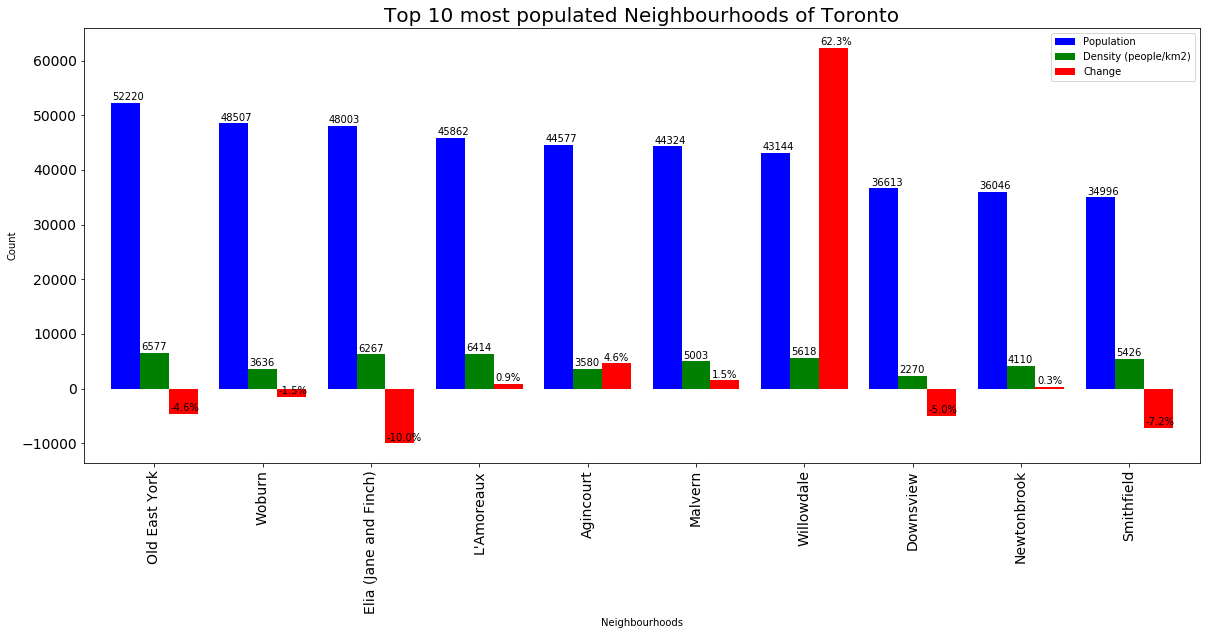

In [110]:
fig = plt.figure()

colors=['blue','green','red']
df_dens['Change'] = df_dens['Change'].apply(lambda x: x * 1000) # multipied by 1000 because change is small value in percentage not visible in plot.
ax = df_dens[['Population', 'Density (people/km2)', 'Change']][:10].plot(kind='bar',color=colors ,figsize=(20, 8), legend=True, fontsize=14, width=0.8)
plt.xlabel('Neighbourhoods')
plt.ylabel('Count')
plt.title('Top 10 most populated Neighbourhoods of Toronto', fontsize=20)
x_offset = -0.12
y_offset = 500
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1+b.y0 ) if n <=19 else (b.y1+b.y0 )/1000)
    if n > 19:
        val += '%'
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show() 

In [111]:
# Checking Neighbourhood with highest income

df_ai = pd.DataFrame(Toronto_Demographics[['Name','Average Income']])
df_ai.drop([0], inplace=True)
df_ai = df_ai.reset_index(drop=True)
df_ai.set_index(['Name'], inplace=True)

income_cleaning=df_ai.loc['Harbord Village','Average Income'].split('C')[0].split(',') # cleaning income for Harboard neighbourhood contain income mixed with string
num1=income_cleaning[0]
num2=income_cleaning[1]
income_cleaned=int(num1+num2)
df_ai.loc['Harbord Village','Average Income']=income_cleaned

df_ai['Average Income']=df_ai['Average Income'].apply(int)
df_ai.head() 

,Average Income
Name,
Agincourt,25750
Alderwood,35239
Alexandra Park,19687
Allenby,245592
Amesbury,27546


### Top 10 highest income neighbourhoods of Toronto

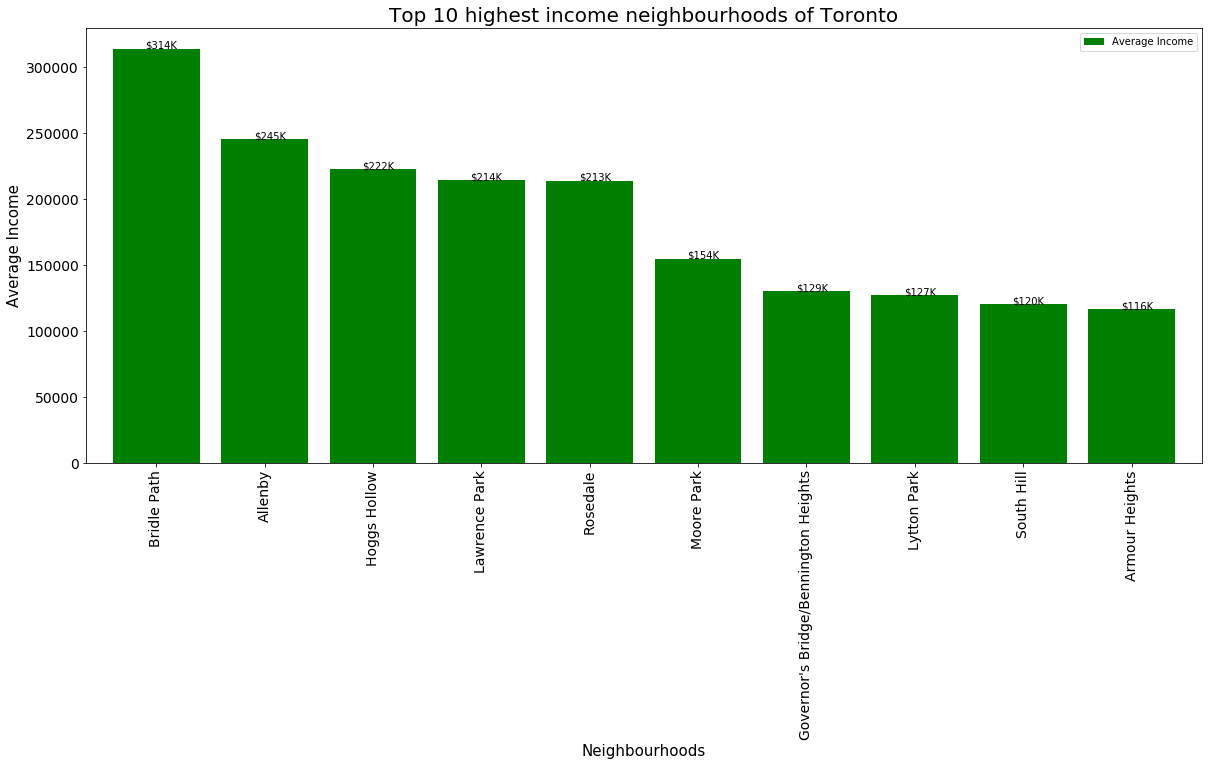

In [112]:
df_ai = df_ai.sort_values(['Average Income'], ascending=False)
ax = df_ai[['Average Income']][:10].plot(kind='bar', figsize=(20, 8), legend=True, fontsize=14, width=0.8,color='green')

plt.xlabel('Neighbourhoods', fontsize=15)
plt.ylabel('Average Income', fontsize=15)
plt.title('Top 10 highest income neighbourhoods of Toronto', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

Text(0.5, 1.0, 'Average Income - Toronto')

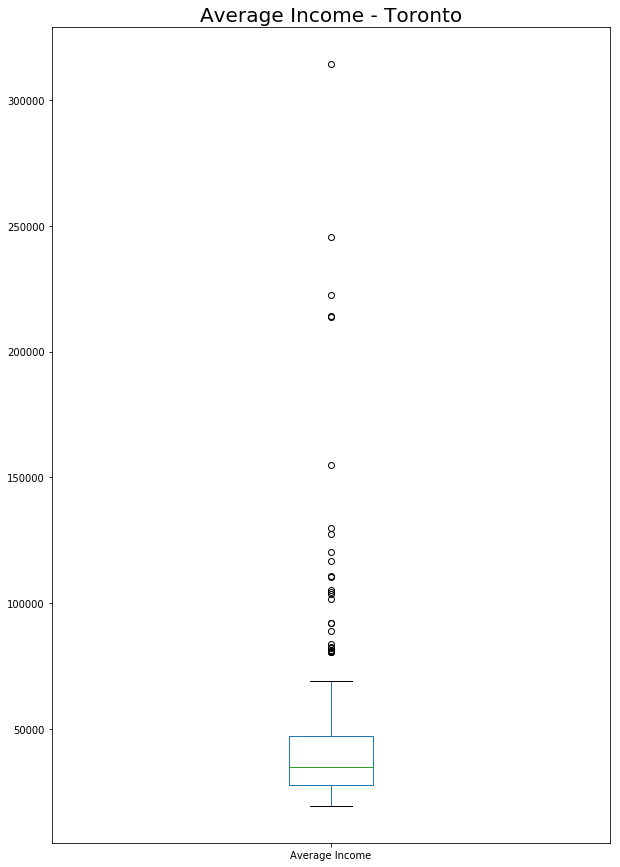

In [113]:
# Average Income of Toronto

df_ai.plot.box(figsize=(10, 15))
plt.title('Average Income - Toronto', fontsize=20)

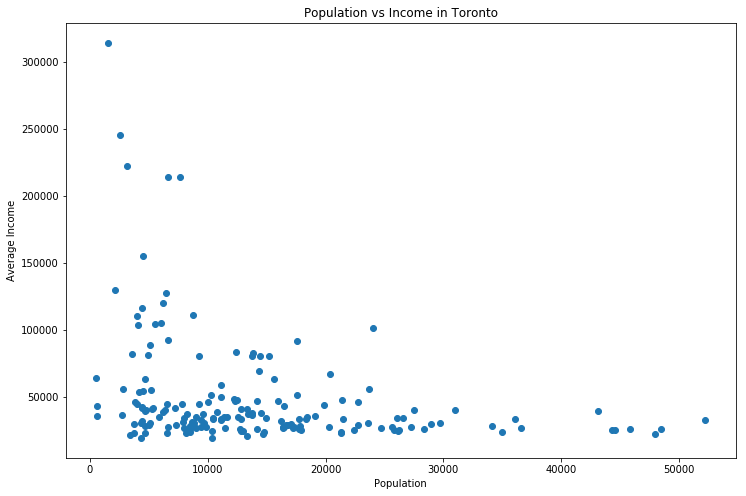

In [114]:
df_ip=pd.DataFrame(Toronto_Demographics[['Population','Average Income']])
df_ip.drop([0,64],inplace=True) # we dropeed 64 index because it contains income with letters and strings

df_ip['Average Income']=df_ip['Average Income'].apply(int)
plt.figure(figsize=(12,8))
plt.scatter(df_ip['Population'],df_ip['Average Income'])
plt.xlabel('Population')
plt.ylabel('Average Income')
plt.title('Population vs Income in Toronto')
plt.show()

In [115]:
Toronto_Demographics=Toronto_Demographics[['Name','Population','Density (people/km2)','Average Income','Second most common language (after English) by percentage']]
Toronto_Demographics.drop([0,64],inplace=True)

Toronto_Demographics=Toronto_Demographics.rename(columns={'Second most common language (after English) by percentage':'Language','Name':'Neighbourhood'})

Toronto_Demographics['Percentage of people speaking language']=Toronto_Demographics['Language'].apply(lambda x : x.split('%')[0] )
Toronto_Demographics['Percentage of people speaking language']=Toronto_Demographics['Percentage of people speaking language'].apply(float)

Toronto_Demographics['Language']=Toronto_Demographics['Language'].apply(lambda x : x.split(' ')[1] if len(x.split(' '))==2 else x.split(' ')[2])
Toronto_Demographics['Average Income']=Toronto_Demographics['Average Income'].apply(int)
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language
1,Agincourt,44577,3580,25750,Cantonese,19.3
2,Alderwood,11656,2360,35239,Polish,6.2
3,Alexandra Park,4355,13609,19687,Cantonese,17.9
4,Allenby,2513,4333,245592,Russian,1.4
5,Amesbury,17318,4934,27546,Spanish,6.1


In [116]:
print('Shape is ', Toronto_Demographics.shape)
Toronto_Demographics.describe()    

Shape is  (173, 6)


,Population,Density (people/km2),Average Income,Percentage of people speaking language
count,173.000000,173.000000,173.000000,173.000000
mean,13929.872832,6210.410405,49354.410405,7.377457
std,10331.176995,6787.874652,42100.865385,6.197637
min,548.000000,94.000000,19521.000000,0.000000
25%,6378.000000,3102.000000,27826.000000,2.700000
50%,11391.000000,4934.000000,34867.000000,5.100000
75%,17740.000000,7556.000000,47515.000000,10.800000
max,52220.000000,63765.000000,314107.000000,31.400000


In [117]:
Toronto_Demographics.describe(include=['O'])

,Neighbourhood,Language
count,173,173
unique,173,27
top,Clairville,Portuguese
freq,1,22


### Plotting Second most common language (after English) spoken in Toronto neighbourhood.

Text(0.5, 1.0, 'Most Speaken language in Toronto')

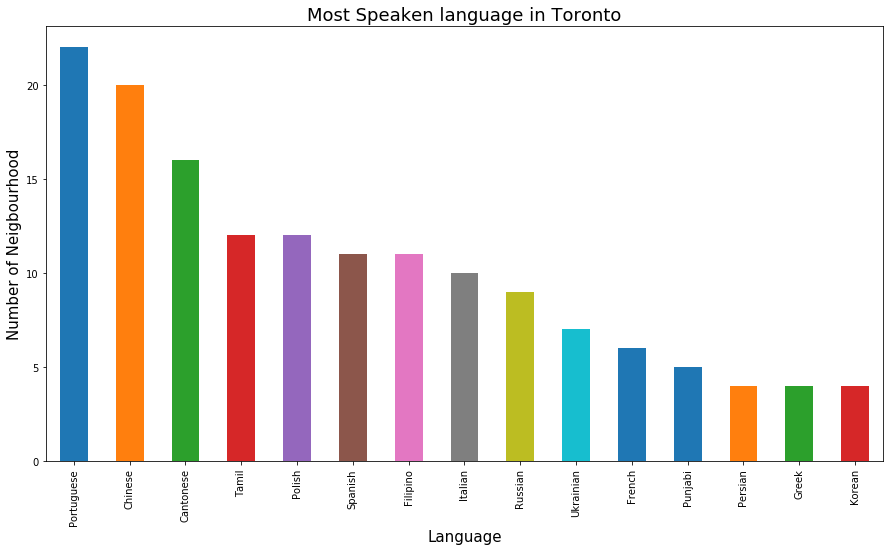

In [118]:
plt.figure(figsize=(15,8))

ax=Toronto_Demographics['Language'].value_counts()[:15].plot(kind='bar')
ax.set_xlabel('Language',fontsize=15)
ax.set_ylabel('Number of Neigbourhood',fontsize=15)

ax.set_title('Most Speaken language in Toronto',fontsize=18)

In [119]:
list_of_neighbourhoods = Toronto_Demographics['Neighbourhood'].values.tolist()

In [120]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


##### Check the neighbourhoods not present in the dataframe Toronto and remove them from the dataframe Toronto_Demographics.

In [121]:
list_missing_neigh = []
for neigh in list_of_neighbourhoods:
    if neigh not in Toronto['Neighbourhood'].values:
        list_missing_neigh.append(neigh)
list_missing_neigh

['Alexandra Park',
 'Allenby',
 'Amesbury',
 'Armour Heights',
 'Banbury',
 'Bay Street Corridor',
 'Bayview Woods – Steeles',
 'Bendale',
 'Bloor West Village',
 'Bracondale Hill',
 'Branson',
 'Bridle Path',
 'Caribou Park',
 'Carleton Village',
 'Casa Loma',
 'Centennial',
 'Chaplin Estates',
 'Christie Pits',
 'Clairville',
 'Corktown',
 'Crescent Town',
 'Cricket Club',
 'Davenport',
 'Discovery District',
 'Distillery District/West Don Lands',
 'Don Mills',
 'Don Valley Village',
 'Dovercourt Park',
 'Downsview',
 'Dufferin Grove',
 'Earlscourt',
 'East Danforth',
 'Eatonville',
 'Eglinton East',
 'Elia (Jane and Finch)',
 'Fairbank',
 'Fashion District',
 'Financial District',
 'Forest Hill',
 'Fort York/Liberty Village',
 'Glen Park',
 "Governor's Bridge/Bennington Heights",
 'Graydon Hall',
 'Harbourfront / CityPlace',
 'Harwood',
 'High Park North',
 'Hillcrest',
 'Hoggs Hollow',
 'Humber Heights',
 'Humber Valley Village',
 'Humbermede',
 'Humberwood',
 'Humewood–Cedarvale',

In [122]:
Toronto_Demographics = Toronto_Demographics[ ~ Toronto_Demographics['Neighbourhood'].isin(list_missing_neigh)]

In [123]:
Toronto_Demographics.reset_index(drop=True,inplace=True)
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language
0,Agincourt,44577,3580,25750,Cantonese,19.3
1,Alderwood,11656,2360,35239,Polish,6.2
2,Bathurst Manor,14945,3187,34169,Russian,9.5
3,Bayview Village,12280,2966,46752,Cantonese,8.4
4,Bedford Park,13749,6057,80827,Greek,0.7


In [124]:
Toronto_Demographics.shape

(77, 6)

#### Drop entries from the dataframe Toronto that are not in the dataframe Toronto_Demographics

In [125]:
list_neigh_dem = Toronto_Demographics['Neighbourhood'].values.tolist()

In [126]:
Toronto = Toronto[Toronto['Neighbourhood'].isin(list_neigh_dem)]
Toronto.reset_index(drop=True)
Toronto.shape

(79, 5)

In [127]:
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language
0,Agincourt,44577,3580,25750,Cantonese,19.3
1,Alderwood,11656,2360,35239,Polish,6.2
2,Bathurst Manor,14945,3187,34169,Russian,9.5
3,Bayview Village,12280,2966,46752,Cantonese,8.4
4,Bedford Park,13749,6057,80827,Greek,0.7


In [128]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
8,M1B,Scarborough,Rouge,43.806686,-79.194353


### Merge the two dataframes to create a dataframe - Toronto_Merged

In [129]:
Toronto_Merged = pd.merge(Toronto, Toronto_Demographics, on='Neighbourhood')
Toronto_Merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,Chinese,3.4
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,Urdu,3.2
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,Italian,15.0
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,Filipino,7.2
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,Tamil,15.6


In [130]:
Toronto_Merged.drop_duplicates(subset=['Neighbourhood'],inplace=True)

In [131]:
Toronto_Merged.shape

(77, 10)

In [132]:
# getting latitude and longitude of the Toronto using geopy
address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
T_lat = location.latitude
T_lon = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(T_lat, T_lon))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


### Create a map of Toronto with neighbourhoods

In [133]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_Merged['Latitude'], Toronto_Merged['Longitude'], Toronto_Merged['Borough'], Toronto_Merged['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

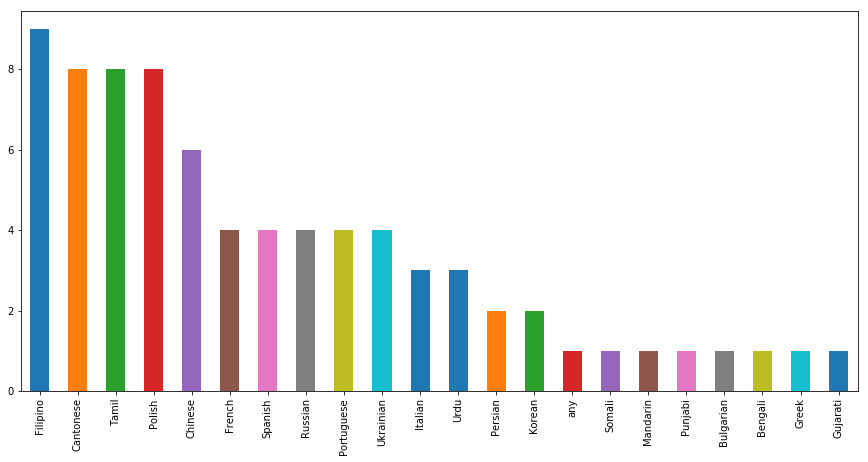

In [134]:
plt.figure(figsize=(15,7))
Toronto_Merged['Language'].value_counts().plot(kind='bar')

### Creating a new dataframe targeting a specific group Chinese.

In [135]:
Toronto_chinese=Toronto_Merged[Toronto_Merged['Language']=='Chinese'] 
Toronto_chinese.sort_values(by=['Percentage of people speaking language','Population'],ascending=False,inplace=True)
Toronto_chinese.reset_index(drop=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language
0,M5T,Downtown Toronto,Grange Park,43.653206,-79.400049,9007,10793,35277,Chinese,14.8
1,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,Chinese,3.4
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,8240,15846,37614,Chinese,3.0
3,M4X,Downtown Toronto,Cabbagetown,43.667967,-79.367675,11120,7943,50398,Chinese,1.6
4,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,7672,2821,213941,Chinese,1.0
5,M1N,Scarborough,Birch Cliff,43.692657,-79.264848,12266,3525,48965,Chinese,0.9


In [136]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(Toronto_chinese['Latitude'], Toronto_chinese['Longitude'], Toronto_chinese['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

In [137]:
# foursquare Credentials
CLIENT_ID = 'JLJ3QFTM1TLSW0SVAGKEIH5YMOMA5PAHEYCBVHFQARTAMAA4'
CLIENT_SECRET = '1H2K25IZ40Q52PS53GIAYNM5SJLR4QLDBNC3HXFGDBNAC140'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JLJ3QFTM1TLSW0SVAGKEIH5YMOMA5PAHEYCBVHFQARTAMAA4
CLIENT_SECRET:1H2K25IZ40Q52PS53GIAYNM5SJLR4QLDBNC3HXFGDBNAC140


## Let's explore neighborhoods near by venues in Toronto.
we will use foursquare api to explore venues in each neighbourhood . below function gives nearby venues in neighbourhood.

In [138]:
def getNearbyVenues(names, avg_income, population, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for names, avg_income, population, lat, lng in zip(names, avg_income, population, latitudes, longitudes):
        print(names)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            names, 
            avg_income, 
            population, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Neighbourhood',
                  'Average_Income',
                  'Population',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [139]:
LIMIT=100
Toronto_venues = getNearbyVenues(Toronto_chinese['Neighbourhood'],Toronto_chinese['Average Income'],Toronto_chinese['Population'],
                                 Toronto_chinese['Latitude'],Toronto_chinese['Longitude']) 

Grange Park
Parkwoods
Garden District
Cabbagetown
Rosedale
Birch Cliff


In [140]:
Toronto_venues.head()

,Neighbourhood,Average_Income,Population,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Grange Park,35277,9007,43.653206,-79.400049,Seven Lives - Tacos y Mariscos,43.654418,-79.400545,Mexican Restaurant
1,Grange Park,35277,9007,43.653206,-79.400049,Kid Icarus,43.653933,-79.401719,Arts & Crafts Store
2,Grange Park,35277,9007,43.653206,-79.400049,Little Pebbles,43.654883,-79.400264,Coffee Shop
3,Grange Park,35277,9007,43.653206,-79.400049,Essence of Life Organics,43.654111,-79.400431,Organic Grocery
4,Grange Park,35277,9007,43.653206,-79.400049,The Moonbean Cafe,43.654147,-79.400182,Café


In [141]:
Toronto_venues.shape

(260, 9)

In [142]:
Toronto_venues.groupby('Neighbourhood').count()

,Average_Income,Population,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,,
Birch Cliff,4,4,4,4,4,4,4,4
Cabbagetown,48,48,48,48,48,48,48,48
Garden District,100,100,100,100,100,100,100,100
Grange Park,100,100,100,100,100,100,100,100
Parkwoods,4,4,4,4,4,4,4,4
Rosedale,4,4,4,4,4,4,4,4


In [143]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 122 uniques categories.


In [144]:
# one hot encoding
toronto_onehot = pd.get_dummies(Toronto_venues['Venue Category'])

# add Postcode column back to dataframe
toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move PostCode column to the first column
cols=list(toronto_onehot.columns)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.loc[:, cols]

toronto_onehot.head()

,Neighbourhood,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Beer Store,...,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Grange Park,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,Grange Park,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,Grange Park,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
3,Grange Park,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,Grange Park,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
toronto_onehot.shape

(260, 123)

In [146]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Beer Store,...,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Birch Cliff,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
1,Cabbagetown,0.00,0.00,0.00,0.00,0.00,0.00,0.041667,0.020833,0.00,0.00,0.020833,...,0.020833,0.00,0.00,0.020833,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2,Garden District,0.01,0.00,0.01,0.00,0.01,0.00,0.010000,0.010000,0.02,0.01,0.000000,...,0.000000,0.01,0.02,0.020000,0.02,0.00,0.01,0.0,0.01,0.01,0.01,0.01
3,Grange Park,0.00,0.01,0.00,0.01,0.00,0.01,0.040000,0.000000,0.07,0.01,0.000000,...,0.000000,0.00,0.01,0.010000,0.00,0.01,0.00,0.0,0.05,0.00,0.05,0.01
4,Parkwoods,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00


In [147]:
toronto_grouped.shape

(6, 123)

In [148]:
toronto_grouped.describe()

,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Beer Store,Belgian Restaurant,...,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0000,6.000000,6.0000,6.000000
mean,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.015278,0.005139,0.015000,0.003333,0.003472,0.001667,...,0.003472,0.001667,0.005000,0.008472,0.003333,0.001667,0.001667,0.041667,0.0100,0.001667,0.0100,0.003333
std,0.004082,0.004082,0.004082,0.004082,0.004082,0.004082,0.020177,0.008667,0.028107,0.005164,0.008505,0.004082,...,0.008505,0.004082,0.008367,0.010034,0.008165,0.004082,0.004082,0.102062,0.0200,0.004082,0.0200,0.005164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032500,0.007500,0.015000,0.007500,0.000000,0.000000,...,0.000000,0.000000,0.007500,0.017500,0.000000,0.000000,0.000000,0.000000,0.0075,0.000000,0.0075,0.007500
max,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.041667,0.020833,0.070000,0.010000,0.020833,0.010000,...,0.020833,0.010000,0.020000,0.020833,0.020000,0.010000,0.010000,0.250000,0.0500,0.010000,0.0500,0.010000


In [149]:
# function to return required number of most common venues.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]  # Leaving the Post Code value in toronto_grouped
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [150]:
# function to return required number of least common venues.
def return_least_common_venues(row, num_least_venues):
    row_categories = row.iloc[1:]  # Leaving the Post Code value in toronto_grouped
    row_categories_sorted = row_categories.sort_values()
    
    return row_categories_sorted.index.values[0:num_least_venues]

### List of most common venues 

In [152]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe 
neighborhoods_venues_most_common = pd.DataFrame(columns=columns)
neighborhoods_venues_most_common['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_most_common.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_most_common.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Birch Cliff,College Stadium,General Entertainment,Café,Skating Rink,Dumpling Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega
1,Cabbagetown,Restaurant,Coffee Shop,Pizza Place,Bakery,Italian Restaurant,Park,Café,Convenience Store,Pub,Market
2,Garden District,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Italian Restaurant,Plaza,Restaurant,Pizza Place,Diner
3,Grange Park,Bar,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Coffee Shop,Bakery,Mexican Restaurant,Chinese Restaurant,Burger Joint
4,Parkwoods,Fast Food Restaurant,Park,Food & Drink Shop,Bus Stop,Farmers Market,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
5,Rosedale,Park,Playground,Trail,Dumpling Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega


### List of least common venues

In [153]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe 
neighborhoods_venues_least_common = pd.DataFrame(columns=columns)
neighborhoods_venues_least_common['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_least_common.iloc[ind, 1:] = return_least_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_least_common.head(10)

,Neighbourhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Birch Cliff,American Restaurant,Other Great Outdoors,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant
1,Cabbagetown,American Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Martial Arts Dojo,Lounge,Lingerie Store,Lake,Juice Bar
2,Garden District,Dim Sum Restaurant,Martial Arts Dojo,Poutine Place,Doner Restaurant,Donut Shop,Dumpling Restaurant,Farmers Market,Playground,Filipino Restaurant,Fish & Chips Shop
3,Grange Park,American Restaurant,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Market,Lounge,Lingerie Store,Lake,Music Venue
4,Parkwoods,American Restaurant,Other Great Outdoors,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant
5,Rosedale,American Restaurant,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant


# 4. Cluster Neighborhoods
Run k-means to cluster the neighborhood into 6 clusters.

In [154]:
k_cluster=6

toronto_grouped_cluster=toronto_grouped.drop('Neighbourhood',axis=1)

cluster_model=KMeans(n_clusters=k_cluster)

cluster_model.fit(toronto_grouped_cluster)

print(cluster_model.labels_) 

[3 4 5 1 0 2]


In [155]:
neighborhoods_venues_least_common.insert(0, 'Cluster Labels', cluster_model.labels_)

In [156]:
Toronto_final=pd.merge(Toronto_chinese,neighborhoods_venues_least_common,on='Neighbourhood')

In [157]:
Toronto_final

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,M5T,Downtown Toronto,Grange Park,43.653206,-79.400049,9007,10793,35277,Chinese,14.8,1,American Restaurant,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Market,Lounge,Lingerie Store,Lake,Music Venue
1,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,Chinese,3.4,0,American Restaurant,Other Great Outdoors,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,8240,15846,37614,Chinese,3.0,5,Dim Sum Restaurant,Martial Arts Dojo,Poutine Place,Doner Restaurant,Donut Shop,Dumpling Restaurant,Farmers Market,Playground,Filipino Restaurant,Fish & Chips Shop
3,M4X,Downtown Toronto,Cabbagetown,43.667967,-79.367675,11120,7943,50398,Chinese,1.6,4,American Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Martial Arts Dojo,Lounge,Lingerie Store,Lake,Juice Bar
4,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,7672,2821,213941,Chinese,1.0,2,American Restaurant,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
5,M1N,Scarborough,Birch Cliff,43.692657,-79.264848,12266,3525,48965,Chinese,0.9,3,American Restaurant,Other Great Outdoors,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant


### Creating a map of locations in Toronto suitable for opening a new business venue targeting chinese population.

In [158]:
# create map
import matplotlib.colors as colors
import matplotlib.cm as cm
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(Toronto_final['Latitude'], Toronto_final['Longitude'], Toronto_final['Neighbourhood'], Toronto_final['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Suggest the following business ventures based on the lowest frequncy of venues in the 1st cluster

In [159]:
Toronto_final[Toronto_final['Cluster Labels']==0]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
1,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,Chinese,3.4,0,American Restaurant,Other Great Outdoors,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant


#### Suggest the following business ventures based on the lowest frequncy of venues in the 2st cluster

In [160]:
Toronto_final[Toronto_final['Cluster Labels']==1]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,M5T,Downtown Toronto,Grange Park,43.653206,-79.400049,9007,10793,35277,Chinese,14.8,1,American Restaurant,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Market,Lounge,Lingerie Store,Lake,Music Venue


#### Suggest the following business ventures based on the lowest frequncy of venues in the 3st cluster

In [161]:
Toronto_final[Toronto_final['Cluster Labels']==2]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
4,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,7672,2821,213941,Chinese,1.0,2,American Restaurant,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant


#### Suggest the following business ventures based on the lowest frequncy of venues in the 4st cluster

In [162]:
Toronto_final[Toronto_final['Cluster Labels']==3]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
5,M1N,Scarborough,Birch Cliff,43.692657,-79.264848,12266,3525,48965,Chinese,0.9,3,American Restaurant,Other Great Outdoors,Organic Grocery,Office,Noodle House,Music Venue,Movie Theater,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant


#### Suggest the following business ventures based on the lowest frequncy of venues in the 5st cluster

In [163]:
Toronto_final[Toronto_final['Cluster Labels']==4]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
3,M4X,Downtown Toronto,Cabbagetown,43.667967,-79.367675,11120,7943,50398,Chinese,1.6,4,American Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Martial Arts Dojo,Lounge,Lingerie Store,Lake,Juice Bar


#### Suggest the following business ventures based on the lowest frequncy of venues in the 6st cluster

In [164]:
Toronto_final[Toronto_final['Cluster Labels']==5]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Language,Percentage of people speaking language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,8240,15846,37614,Chinese,3.0,5,Dim Sum Restaurant,Martial Arts Dojo,Poutine Place,Doner Restaurant,Donut Shop,Dumpling Restaurant,Farmers Market,Playground,Filipino Restaurant,Fish & Chips Shop


#### Checking neighbourhoods with highest population in different cluster

**Parkwoods** Neighbourhhod has highest population.

Text(0.5, 1.0, 'Neighbourhoods with highest population of Chinese')

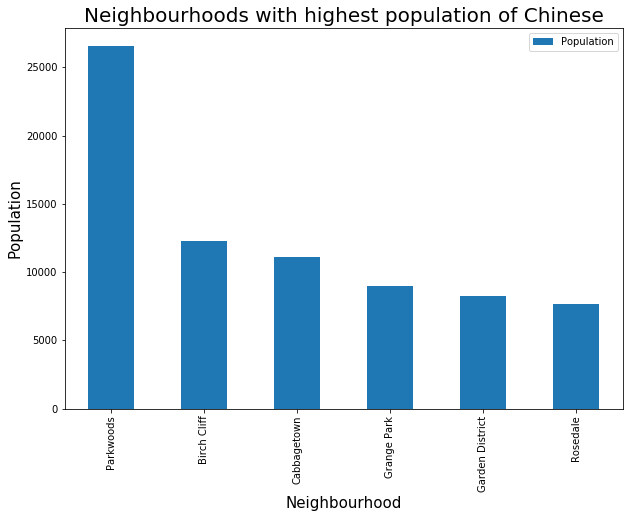

In [165]:
df_population=Toronto_final[['Neighbourhood','Population']].sort_values('Population',ascending=False)
df_population.set_index('Neighbourhood',inplace=True)
ax=df_population.plot(kind='bar',figsize=(10,7),width=0.5)
ax.set_xlabel('Neighbourhood',fontsize=15)
ax.set_ylabel('Population',fontsize=15)
ax.set_title('Neighbourhoods with highest population of Chinese',fontsize=20)

### Checking neighbourhoods with highest income in different cluster

**Rosedale** neighbourhood has highest income

Text(0.5, 1.0, 'Neighbourhoods with highest Income of Chinese')

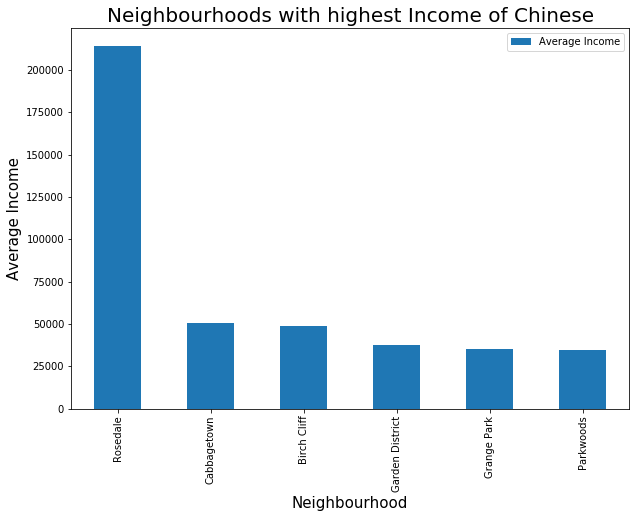

In [166]:
df_income=Toronto_final[['Neighbourhood','Average Income']].sort_values('Average Income',ascending=False)
df_income.set_index('Neighbourhood',inplace=True)
ax=df_income.plot(kind='bar',figsize=(10,7),width=0.5)
ax.set_xlabel('Neighbourhood',fontsize=15)
ax.set_ylabel('Average Income',fontsize=15)
ax.set_title('Neighbourhoods with highest Income of Chinese',fontsize=20)



# Thank you !